In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    RNN,
    Activation,
    Dense,
    Embedding,
    GRUCell,
    LSTMCell,
    Bidirectional,
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import set_random_seed

<IPython.core.display.Javascript object>

In [3]:
news = fetch_20newsgroups()

X = news["data"]
y = news["target"]

<IPython.core.display.Javascript object>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [5]:
X_train_raw = pd.DataFrame(X_train, columns=["text"])
X_test_raw = pd.DataFrame(X_test, columns=["text"])

<IPython.core.display.Javascript object>

In [6]:
pd.set_option("display.max_colwidth", None)

X_train_raw.head()

text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

<IPython.core.display.Javascript object>

# Train data

## Set tokenizer

In [7]:
OOV_TOKEN = "<OOV>"
LOWER = True
CHAR_LEVEL = False
NUM_WORDS = 10000  # Number of terms which will be used for the creating the vocabulary.


tokenizer = Tokenizer(
    oov_token=OOV_TOKEN,
    split=" ",
    lower=LOWER,
    char_level=CHAR_LEVEL,
    num_words=NUM_WORDS,
)

<IPython.core.display.Javascript object>

In [8]:
tokenizer.fit_on_texts(X_train_raw["text"].values)

<IPython.core.display.Javascript object>

In [9]:
index_word = tokenizer.index_word
word_index = {v: k for k, v in tokenizer.index_word.items()}


vocabulary = {i: index_word.get(i) for i in range(1, NUM_WORDS)}
vocabulary_inverse = {w: i for i, w in vocabulary.items()}

<IPython.core.display.Javascript object>

In [10]:
texts_to_sequences_train = tokenizer.texts_to_sequences(X_train_raw["text"].values)

<IPython.core.display.Javascript object>

In [11]:
PADDING = "post"
TRUNCATING = "post"
MAXLEN = 120

sequences_padded_train = pad_sequences(
    texts_to_sequences_train, padding=PADDING, truncating=TRUNCATING, maxlen=MAXLEN
)

<IPython.core.display.Javascript object>

## Test data

In [12]:
texts_to_sequences_test = tokenizer.texts_to_sequences(X_test_raw["text"].values)

<IPython.core.display.Javascript object>

In [13]:
sequences_padded_test = pad_sequences(
    texts_to_sequences_test, padding=PADDING, truncating=TRUNCATING, maxlen=MAXLEN
)

<IPython.core.display.Javascript object>

# Create model

In [14]:
set_random_seed(42)

INPUT_DIM = NUM_WORDS  # Usually len(vocab) + 1
INPUT_LENGTH = MAXLEN  # Length of a sequence
EMBEDDING_DIM = 64

model = Sequential(
    [
        Embedding(
            input_dim=INPUT_DIM,
            output_dim=EMBEDDING_DIM,
            input_length=INPUT_LENGTH,
            weights=None,
            trainable=True,
            name="embedding_layer",
        ),
        RNN(
            cell=LSTMCell(units=128, activation="tanh"),
        ),
        Dense(units=64, activation="relu"),
        Dense(units=20, activation="softmax"),
    ],
    name="simple",
)


OPTIMIZER = Adam(learning_rate=0.01)
LOSS = SparseCategoricalCrossentropy()


model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=["accuracy"])

model.summary()

Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 120, 64)          640000    
                                                                 
 rnn (RNN)                   (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 20)                1300      
                                                                 
Total params: 748,372
Trainable params: 748,372
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [15]:
def train(X_train, y_train, **kwargs):
    history = model.fit(X_train, y_train, **kwargs)
    return history

<IPython.core.display.Javascript object>

In [16]:
history = train(
    sequences_padded_train,
    y_train,
    validation_data=(sequences_padded_test, y_test),
    epochs=10,
    batch_size=128,
)

Epoch 1/10
71/71 [==============================] - 21s 263ms/step - loss: 2.9358 - accuracy: 0.0829 - val_loss: 2.7990 - val_accuracy: 0.0915
Epoch 2/10
71/71 [==============================] - 18s 247ms/step - loss: 2.6444 - accuracy: 0.1457 - val_loss: 2.5505 - val_accuracy: 0.1684
Epoch 3/10
71/71 [==============================] - 18s 248ms/step - loss: 2.1004 - accuracy: 0.2765 - val_loss: 1.8625 - val_accuracy: 0.3544
Epoch 4/10
71/71 [==============================] - 19s 273ms/step - loss: 1.2604 - accuracy: 0.5593 - val_loss: 1.2617 - val_accuracy: 0.6010
Epoch 5/10
71/71 [==============================] - 18s 248ms/step - loss: 0.6344 - accuracy: 0.8018 - val_loss: 0.9328 - val_accuracy: 0.7459
Epoch 6/10
71/71 [==============================] - 17s 245ms/step - loss: 0.3582 - accuracy: 0.8957 - val_loss: 0.9122 - val_accuracy: 0.7693
Epoch 7/10
71/71 [==============================] - 17s 247ms/step - loss: 0.1900 - accuracy: 0.9438 - val_loss: 0.9494 - val_accuracy: 0.7928

<IPython.core.display.Javascript object>

# Testing

In [17]:
inputs = tf.random.uniform(shape=[1, 1, 1])

inputs = tf.convert_to_tensor(np.array([[[1]]]), dtype="float")

<IPython.core.display.Javascript object>

In [18]:
rnn = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(units=2), return_sequences=True, return_state=True)
output = rnn(inputs)



<IPython.core.display.Javascript object>

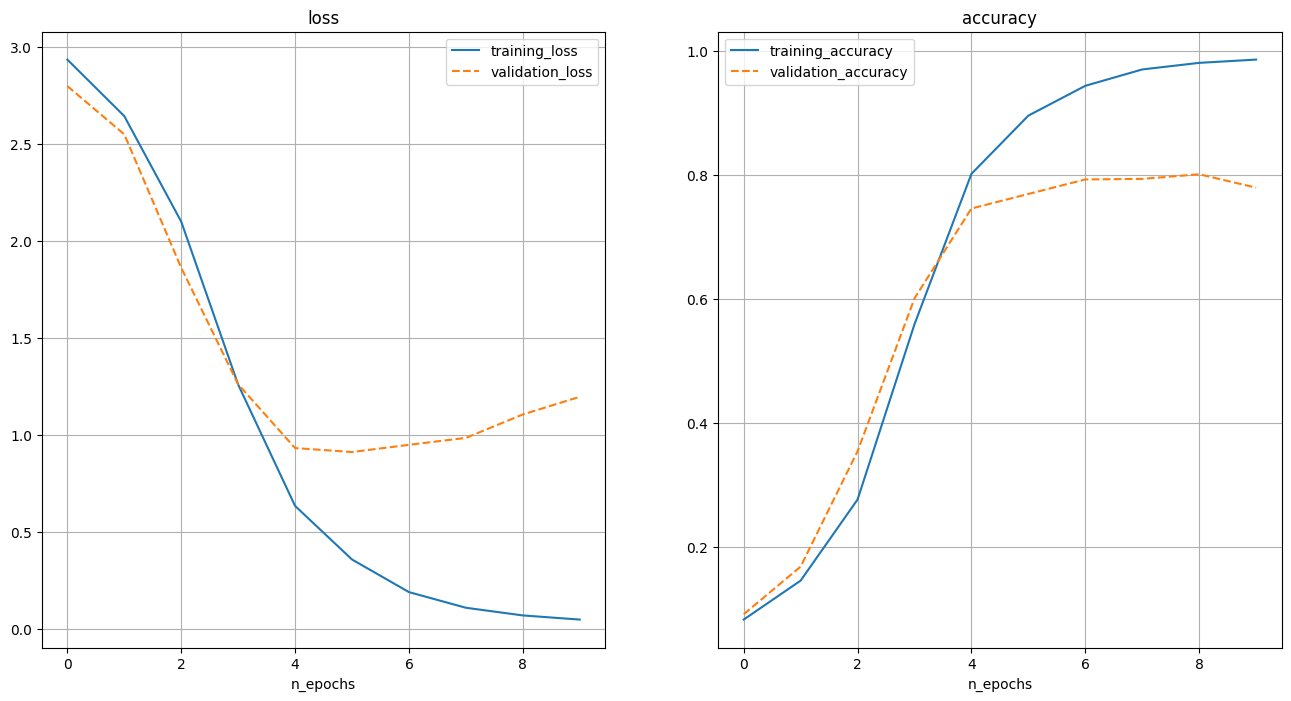

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for idx, label in enumerate(["loss", "accuracy"]):

    ax[idx].plot(history.history[f"{label}"], label=f"training_{label}")
    ax[idx].plot(
        history.history[f"val_{label}"], label=f"validation_{label}", linestyle="--"
    )
    ax[idx].set_title(f"{label}")
    ax[idx].legend()
    ax[idx].grid(True)

    ax[idx].set_xlabel("n_epochs")